[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb)

# Multiclass Regression

In [25]:
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

# Simulate toy data

In [26]:
N = 150

X = np.column_stack((np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N)))

W_true = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [0,0,1]])

a = np.matmul(X, W_true)
y = np.zeros_like(a)
y[np.arange(len(a)), a.argmax(1)] = 1

In [27]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Split the data into training, validation, and testing

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Create Multinomial Logistic Regression model object

In [29]:
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

Check gradients

In [30]:
# check grad
print(mlr.check_grad(X_train, y_train))

1.7795237798812838e-18


Fitting the multinomial logistic model

iter 0: 51.553; 50.686
iter 1: 50.009; 49.064
iter 2: 48.599; 47.590
iter 3: 47.308; 46.247
iter 4: 46.123; 45.020
iter 5: 45.030; 43.894
iter 6: 44.019; 42.856
iter 7: 43.080; 41.897
iter 8: 42.205; 41.005
iter 9: 41.386; 40.174
iter 10: 40.616; 39.395
iter 11: 39.892; 38.663
iter 12: 39.206; 37.973
iter 13: 38.557; 37.320
iter 14: 37.939; 36.700
iter 15: 37.351; 36.111
iter 16: 36.789; 35.549
iter 17: 36.252; 35.012
iter 18: 35.737; 34.498
iter 19: 35.242; 34.004
iter 20: 34.767; 33.531
iter 21: 34.309; 33.075
iter 22: 33.868; 32.636
iter 23: 33.443; 32.213
iter 24: 33.032; 31.804
iter 25: 32.634; 31.409
iter 26: 32.249; 31.027
iter 27: 31.877; 30.657
iter 28: 31.516; 30.299
iter 29: 31.166; 29.951
iter 30: 30.826; 29.614
iter 31: 30.496; 29.287
iter 32: 30.175; 28.970
iter 33: 29.863; 28.661
iter 34: 29.560; 28.360
iter 35: 29.265; 28.068
iter 36: 28.978; 27.784
iter 37: 28.698; 27.507
iter 38: 28.425; 27.237
iter 39: 28.159; 26.974
iter 40: 27.900; 26.717
iter 41: 27.647; 26.467
it

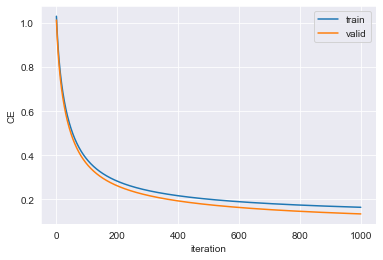

In [31]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

From the above plot, we can see that the training and validation error curves both continue to decrease. Therefore, there is no sign of overfitting.

In [32]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [33]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

1.0
1.0
1.0


In [34]:
print(mlr.W)
print(W_true)

[[-0.52594815  4.01238993 -2.12705594]
 [-1.3639656  -0.49039251  4.04809685]
 [ 6.05834765 -2.5595991  -1.45120515]
 [-1.70312936 -1.05298186  3.42698327]]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


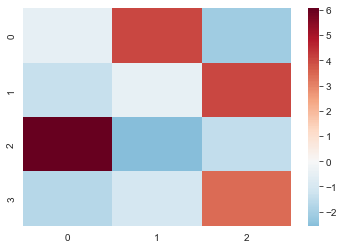

In [35]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

Plot as softmax

In [36]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1)[:,None]
W_hat_transformed

array([[1.05555495e-02, 9.87315681e-01, 2.12876915e-03],
       [4.39582181e-03, 1.05299923e-02, 9.85074186e-01],
       [9.99271873e-01, 1.80699497e-04, 5.47427132e-04],
       [5.81557718e-03, 1.11416188e-02, 9.83042804e-01]])

Now plot the softmax-transformed heatmap, which looks almost identical to groundtruth.

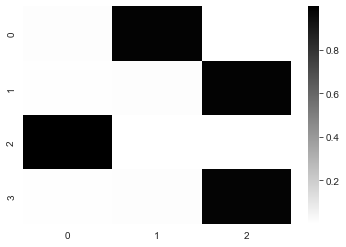

In [37]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

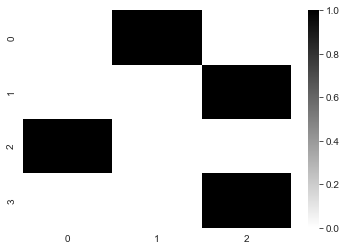

In [38]:
hmp = heatmap(W_true, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_true.png")

# Iris flower classification

In [39]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

print(iris['target_names']) # print flower types
print(iris['feature_names']) # print flower feature names

X = iris.data
y_cat = iris.target

# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

print(y)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 

Once again, we split the data into training, testing, and validation

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.66, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [41]:
mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))

7.277853812682791e-20


iter 0: 35.777; 40.774
iter 1: 30.905; 36.414
iter 2: 27.124; 33.051
iter 3: 24.213; 30.494
iter 4: 21.961; 28.545
iter 5: 20.194; 27.036
iter 6: 18.781; 25.842
iter 7: 17.627; 24.874
iter 8: 16.666; 24.070
iter 9: 15.852; 23.387
iter 10: 15.151; 22.797
iter 11: 14.540; 22.278
iter 12: 14.000; 21.816
iter 13: 13.518; 21.398
iter 14: 13.085; 21.018
iter 15: 12.692; 20.669
iter 16: 12.333; 20.345
iter 17: 12.003; 20.045
iter 18: 11.698; 19.763
iter 19: 11.416; 19.499
iter 20: 11.153; 19.250
iter 21: 10.908; 19.015
iter 22: 10.678; 18.792
iter 23: 10.461; 18.580
iter 24: 10.257; 18.378
iter 25: 10.065; 18.187
iter 26: 9.882; 18.003
iter 27: 9.709; 17.829
iter 28: 9.544; 17.662
iter 29: 9.388; 17.502
iter 30: 9.238; 17.348
iter 31: 9.096; 17.202
iter 32: 8.959; 17.061
iter 33: 8.829; 16.926
iter 34: 8.704; 16.796
iter 35: 8.583; 16.672
iter 36: 8.468; 16.552
iter 37: 8.357; 16.437
iter 38: 8.251; 16.327
iter 39: 8.148; 16.220
iter 40: 8.049; 16.118
iter 41: 7.953; 16.019
iter 42: 7.861; 15

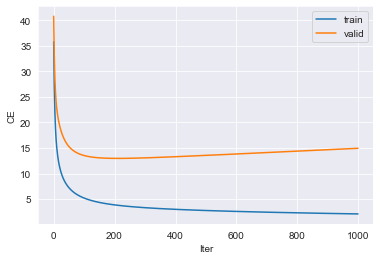

In [42]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.legend()
plt.xlabel("Iter")
plt.ylabel("CE")
plt.savefig("iris_training_ce.png", bbox_inches="tight", dpi=300)

In [43]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
_, _ = mlr.fit(X_train, y_train, niter=optimal_niter) # retrain the model using best niter

iter 0: 39.529
iter 1: 33.491
iter 2: 28.743
iter 3: 25.075
iter 4: 22.256
iter 5: 20.077
iter 6: 18.373
iter 7: 17.017
iter 8: 15.918
iter 9: 15.011
iter 10: 14.250
iter 11: 13.602
iter 12: 13.042
iter 13: 12.553
iter 14: 12.120
iter 15: 11.734
iter 16: 11.386
iter 17: 11.071
iter 18: 10.783
iter 19: 10.519
iter 20: 10.275
iter 21: 10.049
iter 22: 9.839
iter 23: 9.643
iter 24: 9.459
iter 25: 9.286
iter 26: 9.122
iter 27: 8.968
iter 28: 8.822
iter 29: 8.683
iter 30: 8.551
iter 31: 8.425
iter 32: 8.305
iter 33: 8.190
iter 34: 8.080
iter 35: 7.975
iter 36: 7.874
iter 37: 7.777
iter 38: 7.683
iter 39: 7.593
iter 40: 7.506
iter 41: 7.423
iter 42: 7.342
iter 43: 7.264
iter 44: 7.188
iter 45: 7.115
iter 46: 7.044
iter 47: 6.975
iter 48: 6.909
iter 49: 6.844
iter 50: 6.781
iter 51: 6.720
iter 52: 6.661
iter 53: 6.604
iter 54: 6.547
iter 55: 6.493
iter 56: 6.440
iter 57: 6.388
iter 58: 6.337
iter 59: 6.288
iter 60: 6.240
iter 61: 6.193
iter 62: 6.148
iter 63: 6.103
iter 64: 6.059
iter 65: 6.01

Check classification accuracy on training, validation, and testing sets

In [44]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.96
0.8461538461538461
0.696969696969697


Visualize feature weights for each flower class

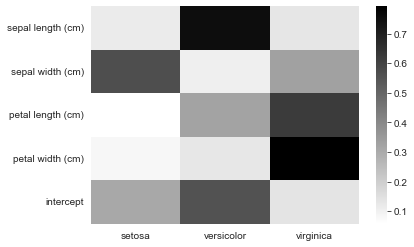

In [45]:
W_hat = mlr.W
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1).reshape(W_hat_transformed.shape[0], 1)

import pandas as pd
iris = datasets.load_iris()
feature_names = iris['feature_names'].copy()
feature_names.append('intercept')
label_names = iris['target_names'].tolist()

W_hat_transformed_df = pd.DataFrame(W_hat_transformed, columns=label_names, index=feature_names)
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("iris_W_hat_transformed.png", bbox_inches="tight", dpi=300)